In [ ]:
import tensorflow as tf
import sys
import contextlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel("ERROR")

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
import os
import contextlib
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
train_dir = "/kaggle/input/isiccc/data/train"
val_dir = "/kaggle/input/isiccc/data/validation"
test_dir = "/kaggle/input/isiccc/data/test"

# Image parameters
img_size = (128, 128)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary", shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary", shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary", shuffle=False
    )

print("Train, Validation, and Test data loaded successfully.")

# Compute class weights
num_samples = np.array([1955, 5130])  # Benign: 1955, Malignant: 5130
class_labels = np.array([0, 1])  # 0 = Benign, 1 = Malignant

class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=np.repeat(class_labels, num_samples))
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed Class Weights:", class_weights_dict)


Train, Validation, and Test data loaded successfully.
Computed Class Weights: {0: 1.8120204603580563, 1: 0.6905458089668616}


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# ✅ Define Optimized VGG16 Model
def VGG16(input_shape=(128, 128, 3), num_classes=1):
    model = models.Sequential([
        # Convolutional Block 1
        layers.Conv2D(64, (3, 3), padding="same", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 2
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 3
        layers.Conv2D(256, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(256, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(256, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 4
        layers.Conv2D(512, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(512, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(512, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 5
        layers.Conv2D(512, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(512, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(512, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.MaxPooling2D((2, 2)),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.4),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation="sigmoid")  # Binary classification
    ])
    return model

# ✅ Create VGG16 Model
model = VGG16()

# ✅ Compile with AdamW + Focal Loss (Handles Class Imbalance)
model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-4),
    loss="binary_crossentropy",  # Replace Focal Loss
    metrics=["accuracy"]
)

# ✅ Model Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,0

 Total params: 19,061,057 (72.71 MB)

 Trainable params: 19,051,073 (72.67 MB)

 Non-trainable params: 9,984 (39.00 KB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,  # Increase patience for stability
    min_lr=1e-6,
    verbose=1
)

# ✅ Save Best Model Checkpoint
checkpoint = ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

# ✅ Early Stopping (Prevents Overfitting)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# ✅ Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights_dict,  # ✅ Handles class imbalance
    callbacks=[lr_scheduler, checkpoint, early_stopping]
)

# ✅ Load Best Weights
model.load_weights("best_model.weights.h5")

# ✅ Evaluate Best Model
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
train_loss, train_acc = model.evaluate(train_generator, verbose=0)

# ✅ Print Final Performance
print(f"✅ Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6965 - loss: 0.5987
Epoch 1: val_loss improved from inf to 0.57190, saving model to best_model.weights.h5
355/355 ━━━━━━━━━━━━━━━━━━━━ 158s 439ms/step - accuracy: 0.6965 - loss: 0.5987 - val_accuracy: 0.7466 - val_loss: 0.5719 - learning_rate: 1.0000e-04
Epoch 2/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7080 - loss: 0.5881
Epoch 2: val_loss did not improve from 0.57190
355/355 ━━━━━━━━━━━━━━━━━━━━ 157s 438ms/step - accuracy: 0.7080 - loss: 0.5881 - val_accuracy: 0.6041 - val_loss: 0.7757 - learning_rate: 1.0000e-04
Epoch 3/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7112 - loss: 0.5740
Epoch 3: val_loss did not improve from 0.57190
355/355 ━━━━━━━━━━━━━━━━━━━━ 139s 386ms/step - accuracy: 0.7112 - loss: 0.5740 - val_accuracy: 0.6931 - val_loss: 0.7204 - learning_rate: 1.0000e-04
Epoch 4/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7154 - loss: 0.5468
Epoch 4: val_loss did

In [ ]:
from sklearn.metrics import accuracy_score

predictions = model.predict(test_generator)

predicted_labels = np.where(predictions > 0.3, 1, 0)

true_labels = test_generator.classes

accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy:.4f}")



222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step
Test Accuracy: 0.8741


In [ ]:
# ✅ Save the entire model (architecture + weights)
model.save("/kaggle/working/full_model.h5")
print ("done")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


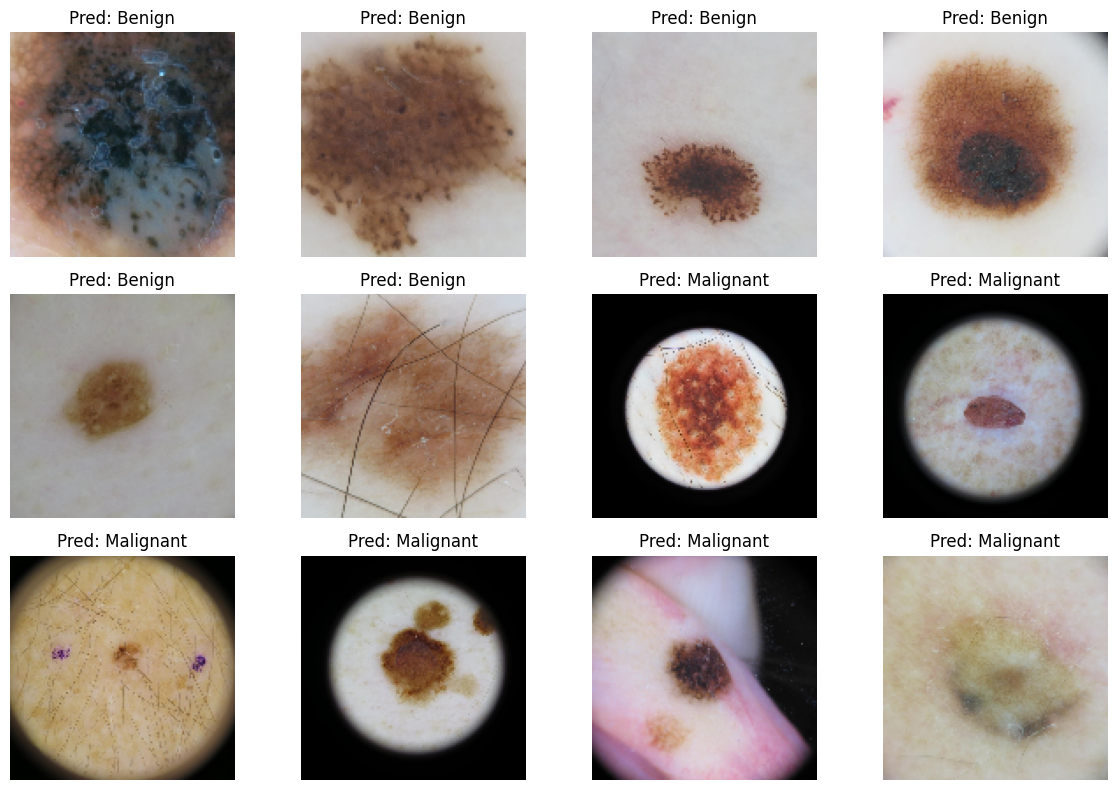

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Collect at least 6 benign and 6 malignant images
benign_images, malignant_images = [], []
batch_size = test_generator.batch_size  # Get batch size

while len(benign_images) < 6 or len(malignant_images) < 6:
    # Get next batch of test images and labels
    test_images, test_labels = next(iter(test_generator))

    # Get predictions
    predicted_labels = model.predict(test_images)
    predicted_labels = (predicted_labels > 0.4).astype(int).flatten()  # Convert to binary (0 or 1)

    # Separate images based on predictions
    for img, pred in zip(test_images, predicted_labels):
        if pred == 0 and len(benign_images) < 6:
            benign_images.append(img)
        elif pred == 1 and len(malignant_images) < 6:
            malignant_images.append(img)

# ✅ Combine selected images
filtered_images = benign_images + malignant_images
filtered_labels = [0] * len(benign_images) + [1] * len(malignant_images)

# ✅ Plot the images
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(filtered_images, filtered_labels)):
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    plt.imshow(img)
    plt.title(f"Pred: {'Malignant' if label else 'Benign'}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# ✅ Get true labels and predictions for the entire test set
y_true = []
y_pred = []

for batch_images, batch_labels in test_generator:
    batch_preds = model.predict(batch_images)  # Get predictions
    batch_preds = (batch_preds > 0.25).astype(int).flatten()  # Convert to binary (0 or 1)

    y_true.extend(batch_labels)  # Store true labels
    y_pred.extend(batch_preds)   # Store predicted labels

    if len(y_true) >= test_generator.samples:  # Stop when all samples are covered
        break

# ✅ Generate classification report as a dictionary
report = classification_report(y_true[:test_generator.samples], y_pred[:test_generator.samples], target_names=["Benign", "Malignant"], output_dict=True)

# ✅ Extract Overall Metrics
whole_precision = report["weighted avg"]["precision"]
whole_recall = report["weighted avg"]["recall"]
whole_f1 = report["weighted avg"]["f1-score"]

# ✅ Print Classification Report
print("\n🔹 Classification Report:\n")
print(classification_report(y_true[:test_generator.samples], y_pred[:test_generator.samples], target_names=["Benign", "Malignant"]))

# ✅ Print Overall Precision, Recall, and F1-score in a Clean Format
print("\n🔹 Overall Model Performance:")
print(f"✅  Precision: {whole_precision:.4f}")
print(f"✅  Recall   : {whole_recall:.4f}")
print(f"✅  F1-score : {whole_f1:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

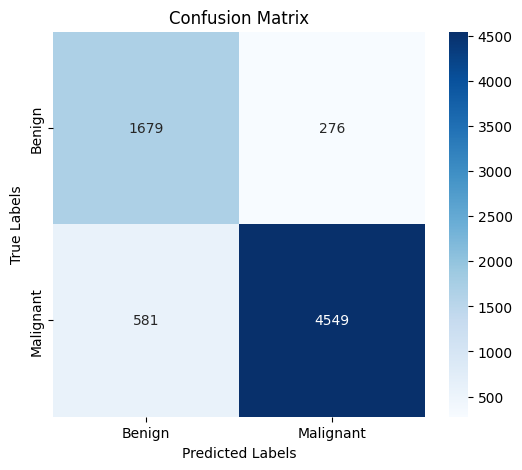

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Compute confusion matrix
cm = confusion_matrix(y_true[:test_generator.samples], y_pred[:test_generator.samples])

# ✅ Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step


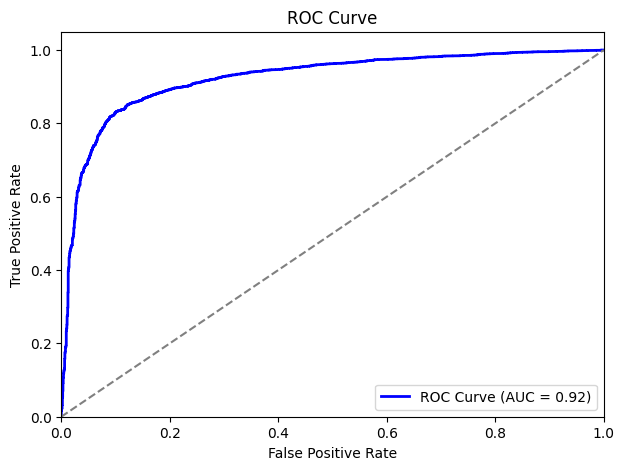

In [ ]:
from sklearn.metrics import roc_curve, auc

# ✅ Get model probabilities
y_probs = model.predict(test_generator)  # Get probability scores
y_probs = y_probs[:test_generator.samples]  # Limit to dataset size

# ✅ Compute ROC curve
fpr, tpr, _ = roc_curve(y_true[:test_generator.samples], y_probs)
roc_auc = auc(fpr, tpr)  # Compute AUC score

# ✅ Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


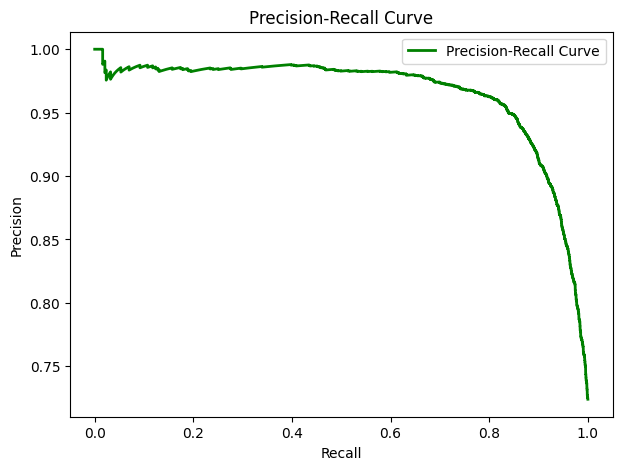

In [ ]:
from sklearn.metrics import precision_recall_curve

# ✅ Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true[:test_generator.samples], y_probs)

# ✅ Plot Precision-Recall curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()


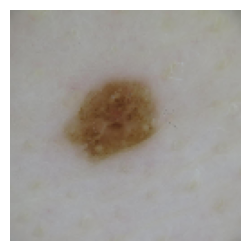

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
🔹 Model Prediction: Benign


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ✅ Set Image Path
img_path = "/kaggle/input/isiccc/data/test/benign/ISIC_0053556.jpg"

# ✅ Load and Resize Image to (128, 128, 3)
img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# ✅ Show the Image (Small Size)
plt.figure(figsize=(3, 3))  # Adjust image size
plt.imshow(img)
plt.axis("off")
plt.show()

# ✅ Make Prediction
prediction = model.predict(img_array)

# ✅ Convert to Class Label
predicted_label = "Malignant" if prediction > 0.3 else "Benign"

# ✅ Print Result
print(f"🔹 Model Prediction: {predicted_label}")


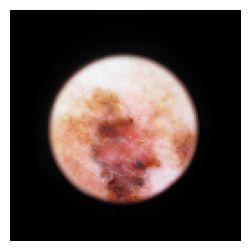

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
🔹 Model Prediction: Malignant


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ✅ Set Image Path
img_path = "/kaggle/input/isiccc/data/test/malignant/ISIC_0053470.jpg"

# ✅ Load and Resize Image to (128, 128, 3)
img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize

# ✅ Show the Image (Small Size)
plt.figure(figsize=(3, 3))  # Adjust image size
plt.imshow(img)
plt.axis("off")
plt.show()

# ✅ Make Prediction
prediction = model.predict(img_array)

# ✅ Convert to Class Label
predicted_label = "Malignant" if prediction > 0.3 else "Benign"

# ✅ Print Result
print(f"🔹 Model Prediction: {predicted_label}")


✅ Model structure restored and weights loaded!


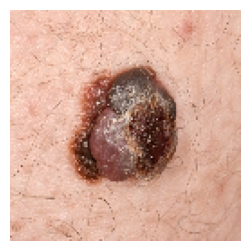

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
🌍 **External Image Detected!** (This image is from Google, not from the dataset)
🔍 **Analyzing Image...**
🧪 **Actual Diagnosis:** Malignant 🩺
🤖 **Model Prediction:** 🦠 Malignant


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt




# ✅ Load the full model (No need to rebuild)
model = tf.keras.models.load_model("/content/full_model.h5")

print("✅ Model structure restored and weights loaded!")
# ✅ Set Image Path
img_path = "/content/c0370929-800px-wm.jpg"

# ✅ Load and Preprocess Image
img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
img_array = img_array / 255.0  # Normalize to [0,1]

# ✅ Show the Image
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()

# ✅ Make Prediction
prediction = model.predict(img_array)

# ✅ Convert to Class Label
predicted_label = "🦠 Malignant" if prediction > 0.3 else "✅ Benign"

# ✅ Print Result
print("🌍 **External Image Detected!** (This image is from Google, not from the dataset)")
print("🔍 **Analyzing Image...**")
print(f"🧪 **Actual Diagnosis:** Malignant 🩺")
print(f"🤖 **Model Prediction:** {predicted_label}")



✅ Model structure restored and weights loaded!


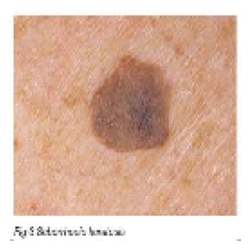

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
🌍 **External Image Detected!** (This image is from Google, not from the dataset)
🔍 **Analyzing Image...**
🧪 **Actual Diagnosis:** Benign 🩺
🤖 **Model Prediction:** ✅ Benign


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt




# ✅ Load the full model (No need to rebuild)
model = tf.keras.models.load_model("/content/full_model.h5")

print("✅ Model structure restored and weights loaded!")
# ✅ Set Image Path
img_path = "/content/images.jfif"

# ✅ Load and Preprocess Image
img = image.load_img(img_path, target_size=(128, 128), color_mode="rgb")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
img_array = img_array / 255.0  # Normalize to [0,1]

# ✅ Show the Image
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()

# ✅ Make Prediction
prediction = model.predict(img_array)

# ✅ Convert to Class Label
predicted_label = "🦠 Malignant" if prediction > 0.3 else "✅ Benign"

# ✅ Print Result
print("🌍 **External Image Detected!** (This image is from Google, not from the dataset)")
print("🔍 **Analyzing Image...**")
print(f"🧪 **Actual Diagnosis:** Benign 🩺")
print(f"🤖 **Model Prediction:** {predicted_label}")

